In [1]:
cd ..

/Users/adamnavarroliriano/Documents/Personal/Code/language/language-api


/Users/adamnavarroliriano/miniconda3/envs/language-api/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import pandas as pd
import numpy as np 
import ast
from plotnine import *
from itertools import permutations
from sacrebleu.metrics import BLEU
from sacrebleu import sentence_bleu
from src.models.pretrained import load_pretrained_model
import time
import os
import scipy.stats as st
from collections import Counter
from itertools import chain

/Users/adamnavarroliriano/miniconda3/envs/language-api/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Metadata

In this section we focus on understanding the amount of data we have for each language pair. 

In future plots, we will refer to language mix A+B to any language pair that involves two languages A and B

In [3]:
with open('data/train.metadata') as f:
    metadata = f.readlines()
    
metadata = [ast.literal_eval(line.strip()) for line in metadata]
metadata_df = pd.DataFrame(metadata)
metadata_df['lang_mix'] = metadata_df[['src_lang', 'tgt_lang']].apply(lambda x: '+'.join(sorted(x)), axis=1)

In [4]:
language_pairs_qty = metadata_df.groupby(['src_lang', 'tgt_lang', 'lang_mix']).size().reset_index().rename(columns={0:'obs'})
language_pairs_qty['language_pair'] = language_pairs_qty['src_lang'] + ' - ' + language_pairs_qty['tgt_lang']
language_pairs_qty.sort_values(by='obs')

,src_lang,tgt_lang,lang_mix,obs,language_pair
10,sv,en,en+sv,89513,sv - en
4,en,nb,en+nb,89786,en - nb
9,sv,da,da+sv,93665,sv - da
7,nb,en,en+nb,99447,nb - en
0,da,en,da+en,103097,da - en
3,en,da,da+en,108729,en - da
5,en,sv,en+sv,139502,en - sv
8,nb,sv,nb+sv,141412,nb - sv
1,da,nb,da+nb,150826,da - nb
11,sv,nb,nb+sv,152931,sv - nb


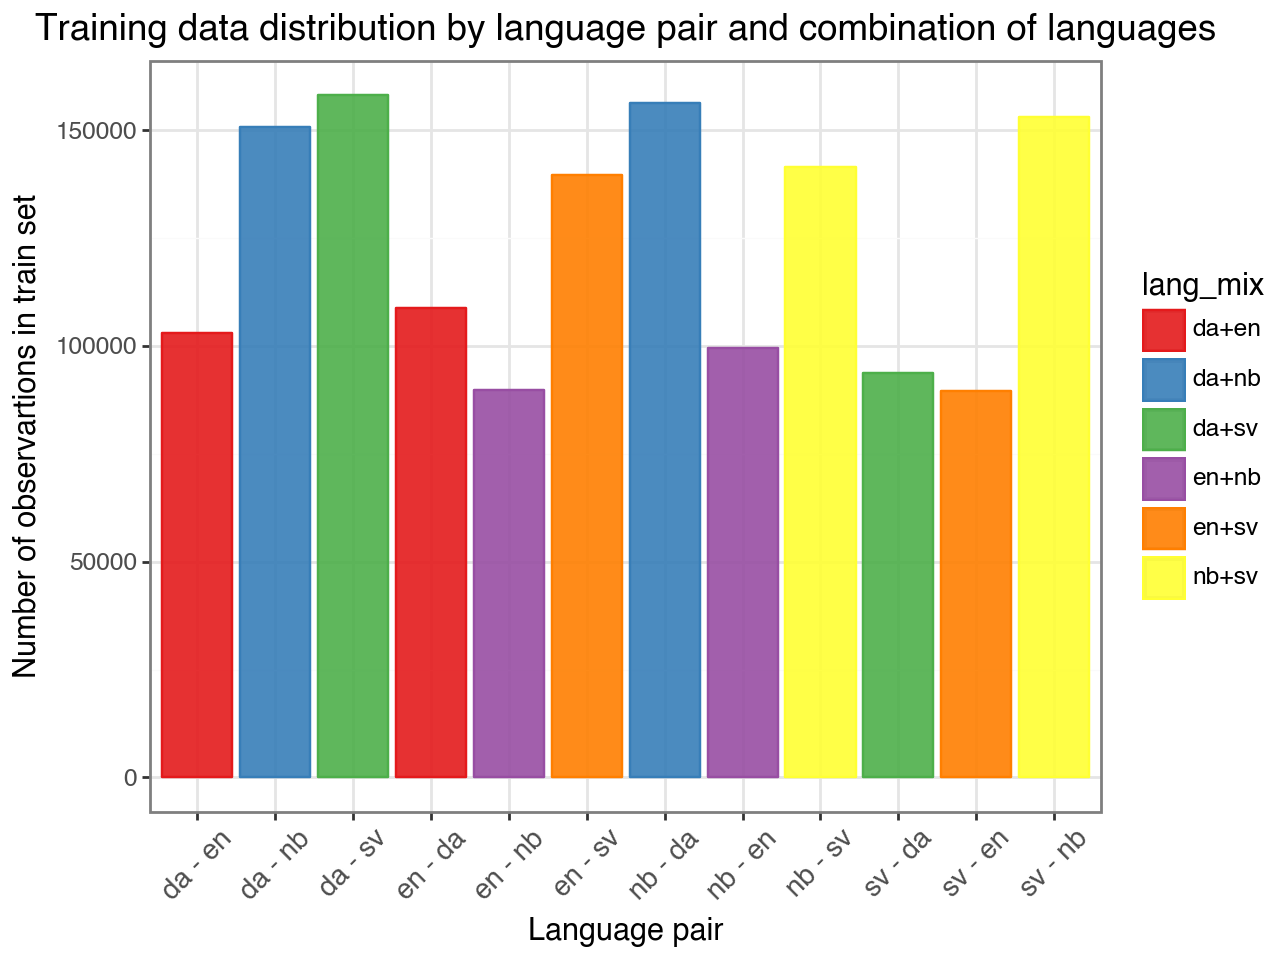

In [5]:
(
    ggplot(language_pairs_qty, aes(x='language_pair', y='obs', fill='lang_mix', color='lang_mix')) +
    geom_bar(stat='identity', alpha=0.9) +
    scale_fill_brewer(type='qual', palette='Set1') + 
    scale_color_brewer(type='qual', palette='Set1') +
    theme_bw() + 
    theme(axis_text_x= element_text(angle=45, size=10)) +
    labs(x='Language pair', y='Number of observartions in train set', title='Training data distribution by language pair and combination of languages')
    
)

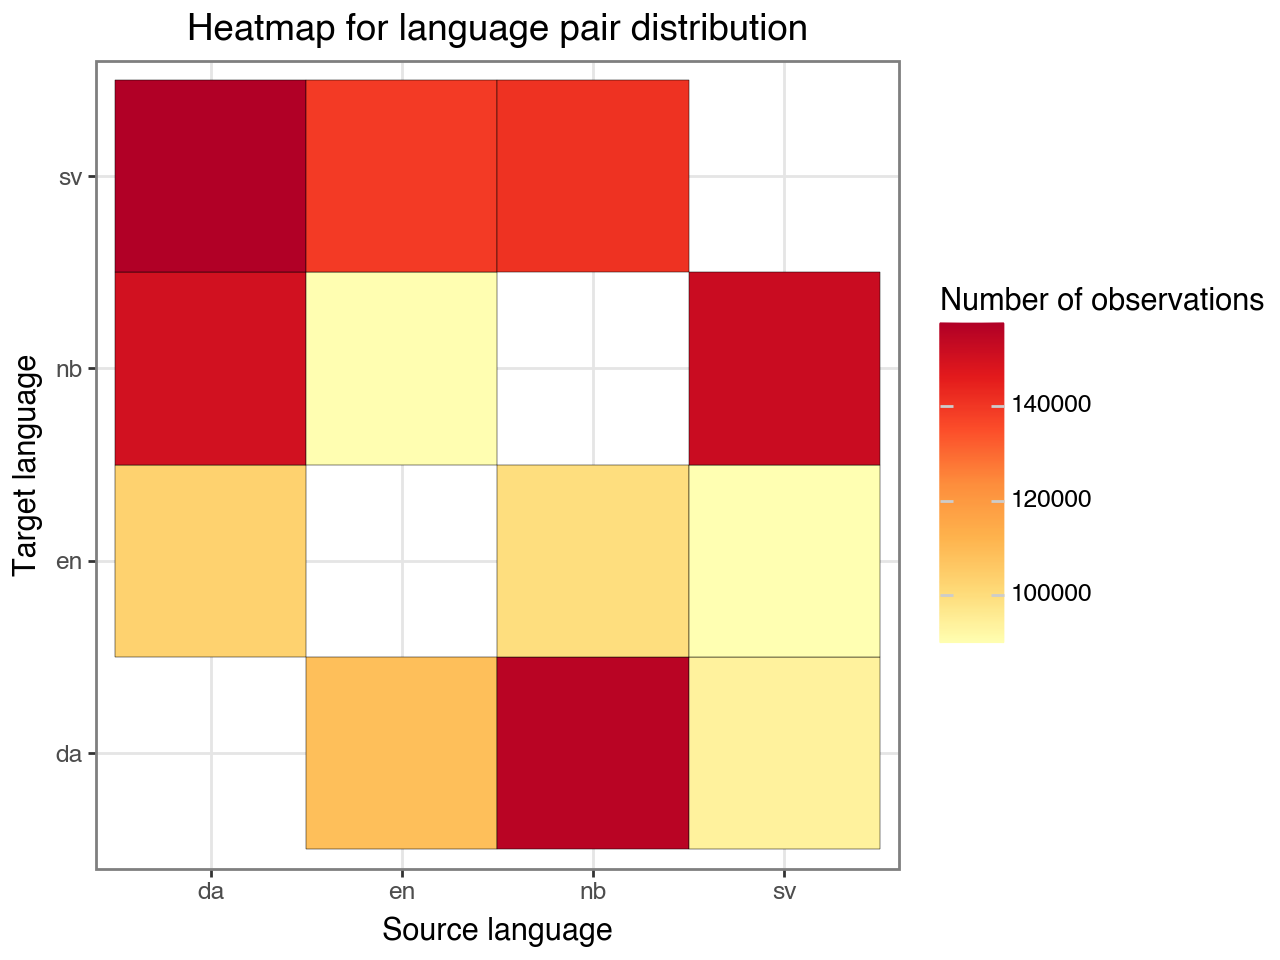

In [6]:
(
    ggplot(language_pairs_qty, aes(x='src_lang', y='tgt_lang', fill='obs')) +
    geom_tile(color='black') +
    scale_fill_distiller(palette='YlOrRd', 
                         limits=[language_pairs_qty['obs'].min(), language_pairs_qty['obs'].max()],
                         direction=1) +
    theme_bw() +
    labs(title='Heatmap for language pair distribution', 
        x='Source language', 
        y='Target language', 
        fill='Number of observations')
    
)

### Conclusions
* Training data ranges from 89K to 158K observations for each language pair.
  
* The combination of languages less represented is **{en, nb}**.

* The combination of languages more represented is **{da, nb}**.

* As a source language, **da** contains the most amount of observations, while **en** and **sv** contain the least.

* As a target language, **da** contains the most amount of translations, while **en** contains the least.

* Language mixes (combinations of languages) for **{da, sv}** and **{en, sv}** are the most imbalanced in terms of observations. 

## Distributions (lens, tokens and characters)

In this section, we focus on understanding the distribution of string lengths for each source and target text, under each pair of languages. We also look at tokens and characters

In [7]:
with open('data/train.src', 'r') as f:
    train_src = f.readlines()

with open('data/train.tgt', 'r') as f:
    train_tgt = f.readlines()

In [8]:
translation_df = metadata_df.copy()
translation_df['src_text'] = train_src
translation_df['tgt_text'] = train_tgt

# Strip trailing spaces
translation_df['src_text'] = translation_df['src_text'].str.strip()
translation_df['tgt_text'] = translation_df['tgt_text'].str.strip()

# Compute character lens
translation_df['src_len'] = translation_df['src_text'].str.len()
translation_df['tgt_len'] = translation_df['tgt_text'].str.len()

In [9]:
translation_df[['src_len', 'tgt_len']].corr()

,src_len,tgt_len
src_len,1.000000,0.979144
tgt_len,0.979144,1.000000


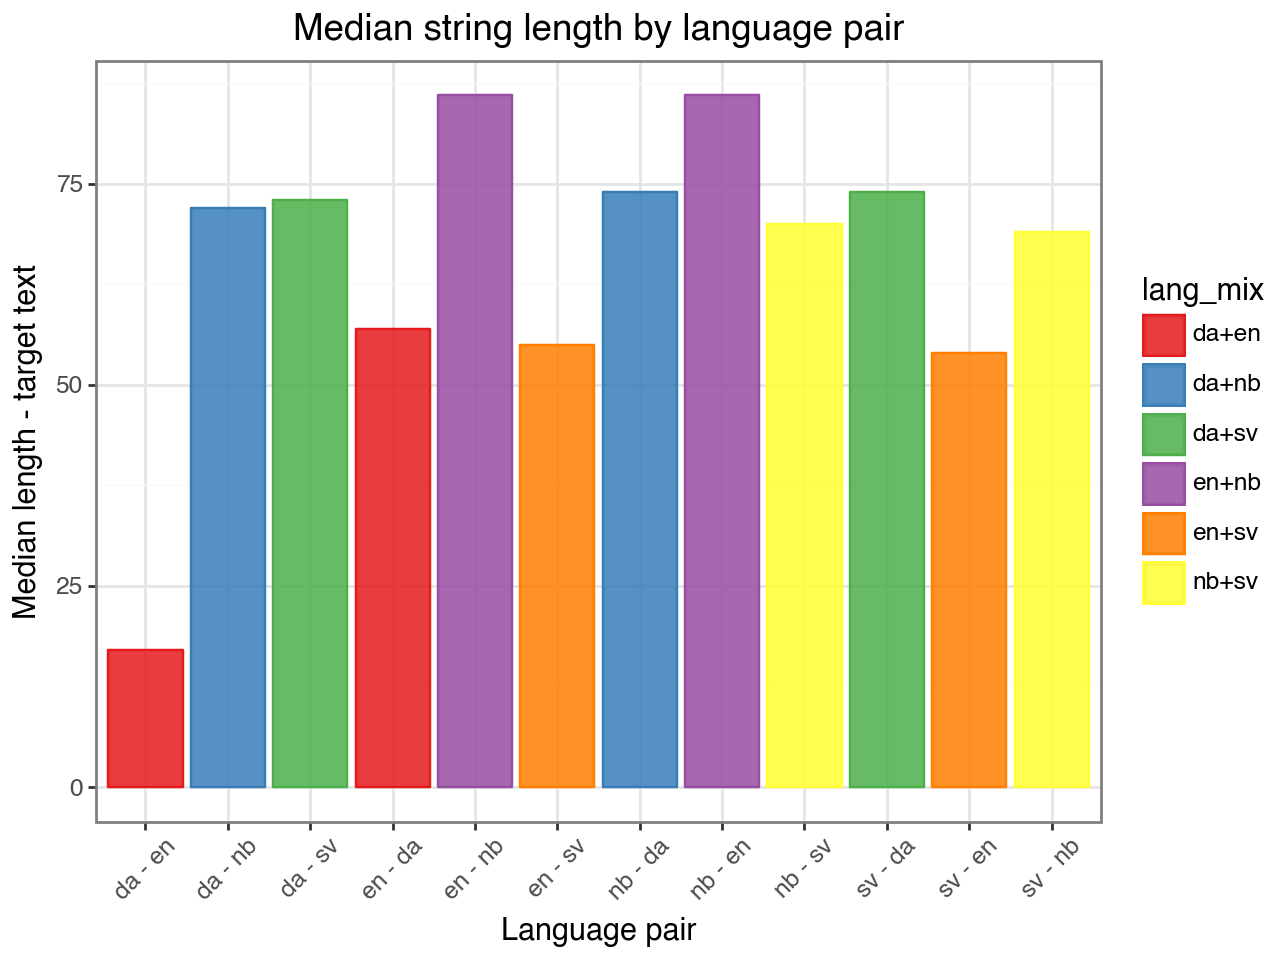

In [10]:
# Aggregate
len_distribution_df = (translation_df
 .groupby(['src_lang', 'tgt_lang', 'lang_mix'])[['src_len', 'tgt_len']]
 .agg(['mean', 'median', 'min', 'max', ('p90', lambda x: np.quantile(x, 0.95))])
 .reset_index()
)
len_distribution_df.columns=[col[0] if col[1]=='' else '_'.join(col) for col in len_distribution_df.columns]
len_distribution_df['language_pair'] = len_distribution_df['src_lang'] + ' - ' + len_distribution_df['tgt_lang']

(
    ggplot(len_distribution_df, aes(x='language_pair', y='tgt_len_median', fill='lang_mix', color='lang_mix')) +
    geom_bar(stat='identity', alpha=0.85) +
    theme_bw() + 
    scale_fill_brewer(type='qual', palette='Set1') + 
    scale_color_brewer(type='qual', palette='Set1') +
    theme(axis_text_x= element_text(angle=45)) +
    labs(title='Median string length by language pair', x='Language pair', y='Median length - target text')
    
)

In [11]:
translation_df['src_tokens'] = translation_df['src_text'].str.split().apply(len)
translation_df['tgt_tokens'] = translation_df['tgt_text'].str.split().apply(len)

In [12]:
translation_df[['src_tokens', 'tgt_tokens']].corr()

,src_tokens,tgt_tokens
src_tokens,1.00000,0.97005
tgt_tokens,0.97005,1.00000


In [13]:
translation_df.groupby(['src_lang', 'tgt_lang'])[['src_tokens', 'tgt_tokens']].agg(['median', ('p90', lambda x: np.quantile(x, 0.9))])

src_tokens       tgt_tokens      
                      median   p90     median   p90
src_lang tgt_lang                                  
da       en              2.0  36.0        3.0  37.0
         nb             12.0  26.0       12.0  26.0
         sv             12.0  28.0       12.0  27.0
en       da              9.0  43.0        9.0  41.0
         nb             14.0  29.0       14.0  28.0
         sv             10.0  26.0       10.0  24.0
nb       da             12.0  26.0       12.0  26.0
         en             14.0  28.0       14.0  29.0
         sv             12.0  26.0       11.0  25.0
sv       da             12.0  27.0       12.0  28.0
         en              9.0  24.0       10.0  26.0
         nb             11.0  25.0       12.0  26.0

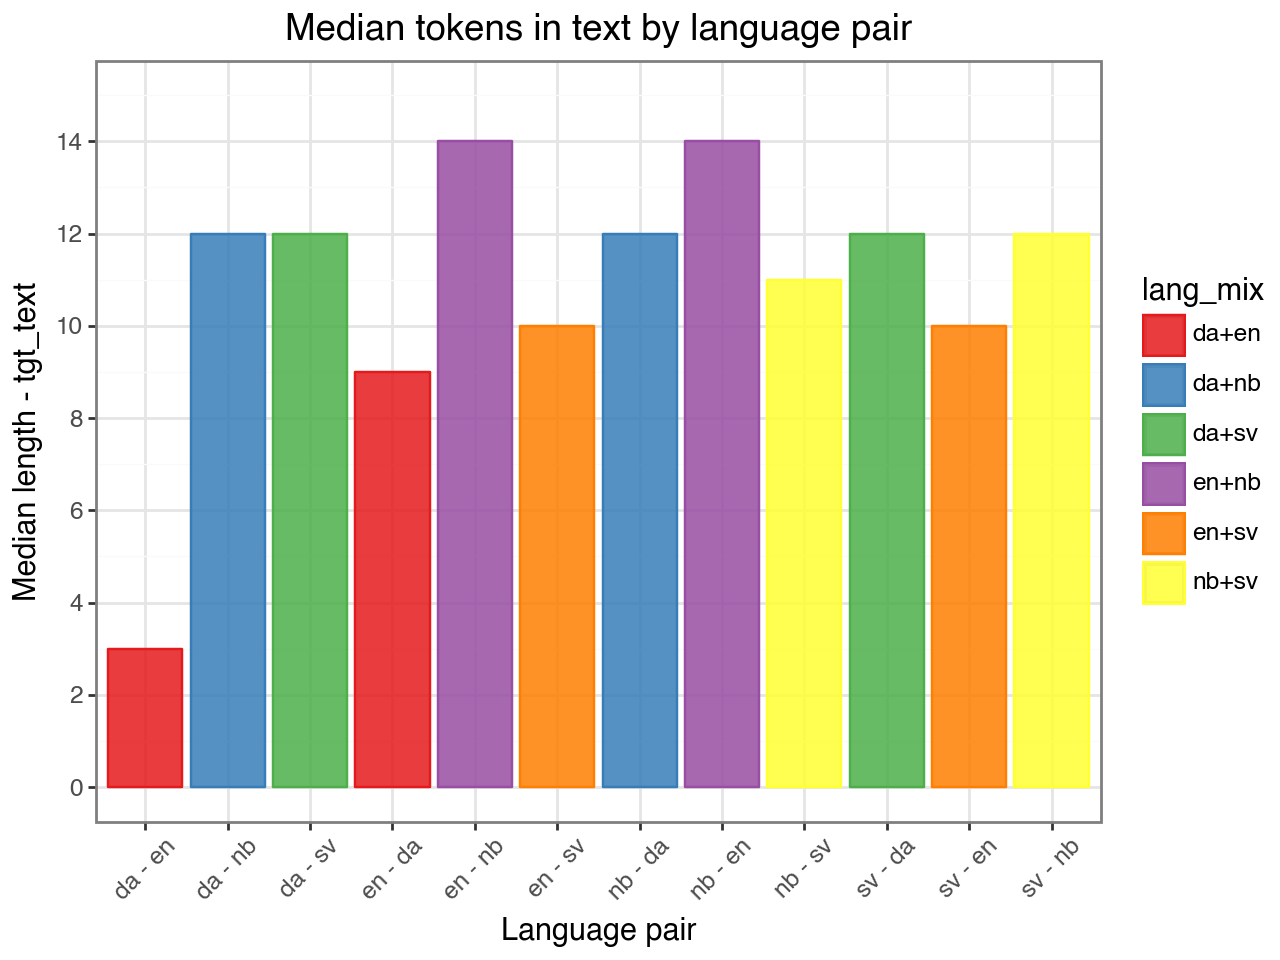

In [14]:
token_distribution = (translation_df
                      .groupby(['src_lang', 'tgt_lang', 'lang_mix'])[['src_tokens', 'tgt_tokens']]
                      .agg(['median', ('p90', lambda x: np.quantile(x, 0.9))])
                      .reset_index()
                     )
token_distribution.columns=[col[0] if col[1]=='' else '_'.join(col) for col in token_distribution.columns]
token_distribution['language_pair'] = token_distribution['src_lang'] + ' - ' + token_distribution['tgt_lang']

(
    ggplot(token_distribution, aes(x='language_pair', y='tgt_tokens_median', fill='lang_mix', color='lang_mix')) +
    geom_bar(stat='identity', alpha=0.85) +
    theme_bw() + 
    scale_y_continuous(limits=[0, token_distribution['tgt_tokens_median'].max() + 1], 
                      breaks=np.arange(0, token_distribution['tgt_tokens_median'].max() + 1, 2)) +
    scale_fill_brewer(type='qual', palette='Set1') + 
    scale_color_brewer(type='qual', palette='Set1') +
    theme(axis_text_x= element_text(angle=45)) +
    labs(title='Median tokens in text by language pair', x='Language pair', y='Median length - tgt_text')
    
)

In [ ]:
text_chars = pd.Series(
    Counter(
        chain.from_iterable(translation_df['src_text'].tolist() + translation_df['tgt_text'].tolist())
    )
)
text_chars_df = text_chars.sort_values(ascending=False).reset_index().rename(columns={'index':'char', 0:'qty'})

In [ ]:
text_chars_df = text_chars_df.loc[text_chars_df['char']!=' '].reset_index(drop=True)
text_chars_df['pct'] = text_chars_df['qty'] / text_chars_df['qty'].sum()
text_chars_df['pct_cumm'] = text_chars_df['pct'].cumsum()

chars_99_pct = text_chars_df.loc[0:(text_chars_df.pct_cumm >= 0.999).idxmax()]
chars_under_100 = text_chars_df.loc[text_chars_df['qty'] < 100]

print(f"""{chars_99_pct.shape[0]} distinct characters cover 99.9% of the character distribution.
The rest is split among {text_chars_df.shape[0] - chars_99_pct.shape[0]} characters""")
print('\n--\n')
print(f"""{chars_under_100.shape[0]} distinct characters have less than 100 appeareances in the dataset""")



In [ ]:
chars_under_100

### Conclusions
* Texts comming from the **da-en** language pair are generally shorter than the rest of the language pairs. Behavior from the **en-da** language pair is also not very similar to the inverse language pair, which generally doesn't happen in the rest of the dataset.
  
* Generally, there is high correlation on both the string length and word counts, from source and target text, for all language pairs.

  
* There are special characters in the translations (emojis, symbols, etc.). They are however not very represented.

## BLEU scores for samples

An interesting insight to gather before training models is to understand the quality of the current models. 

To do this, we go to HuggingFace and download pretrained Machine Translation (MT) models for each language pair. We would like to quantify the BLEU of the models for each language pair. We are using this metric as it a standard evaluation metric in MT, though other metrics can be used.

To compute BLEU score for each pair, we use a Kaggle GPU. We focus on the [Marian family of models from the Language Technology Research Group at the University of Helsinki](https://huggingface.co/docs/transformers/en/model_doc/marian).
The notebook in which the pretrained models was used is [here](./1.1-kaggle-translations-bleu-pretrained.ipynb).

In [ ]:
translation_df.to_parquet('data/translation_merged.parquet', index=False)

### Results

A key finding is that the 'nb' language code that stands for Norwegian Bokmål is not generally suported for Machine Translation tasks. Upon further research, we found that this standard of Norwegian is the most popular written form for the language, and we can almost safely replace it with the language code 'no'

After running the translations through models, we find that there are 4 language pairs which are not supported by the family of MarianMT models. In particular, the following language pairs, even after substituting 'nb' for 'no'
* en-nb
* sv-da
* da-sv
* nb-en

In [ ]:
files_translations = os.listdir('data/kaggle/')
files_translations = [file for file in files_translations if file.endswith('.csv')]
bleu_scores = pd.concat([pd.read_csv(f"data/kaggle/{file}") for file in files_translations])

We are also are going to assume that the case is not important to compute BLEU, just to get an upper bound of the metric.

In [ ]:
def bootstrap(array:pd.Series, func:callable,  times=1000, seed=0):
    resample_results =[]

    for i in range(times):
        agg_value = func(array.sample(frac=1, replace=True, random_state=seed + i))
        resample_results.append(agg_value)
    
    return resample_results
    

In [ ]:
# Compute BLEU in lower case, assuming it is not important for the use case
bleu_scores['bleu'] - bleu_scores.apply(lambda x: sentence_bleu(x['translation'], [x['tgt_text']]).score, axis=1)
bleu_scores['bleu_lowercase'] = bleu_scores.apply(lambda x: sentence_bleu(x['translation'].lower(), [x['tgt_text'].lower()]).score, axis=1)

# Sort by lang_pair and src_text to ensure reproducibility in bootstrap interval
bleu_scores = bleu_scores.sort_values(by=['lang_pair', 'src_text']).reset_index(drop=True)

Now we compute the mean and a confidence interval for the BLEU mean at 90% confidence level.

In [ ]:
agg_bleu_scores = bleu_scores.groupby('lang_pair')[['bleu', 'bleu_lowercase']].mean()

# Compute bootstrap array for the mean value of BLEU scores
bs_bleu_scores = bleu_scores.groupby('lang_pair')[['bleu', 'bleu_lowercase']].agg(lambda x: bootstrap(x, func=np.mean, times=1000, seed=0))
agg_bleu_scores.loc[:, ['bleu_array', 'bleu_lowercase_array']] = bs_bleu_scores.values

# Compute lower and upper bounds for the confidence interval at 90 level
p = 0.9
quantiles = [(1-p)/2, (1+p)/2]
agg_bleu_scores

# Split the lower bounds
agg_bleu_scores.loc[:, ['bleu_lower', 'bleu_upper']] = agg_bleu_scores['bleu_array'].apply(lambda x: np.quantile(x, quantiles)).apply(pd.Series).values
agg_bleu_scores.loc[:, ['bleu_lowercase_lower', 'bleu_lowercase_upper']] = agg_bleu_scores['bleu_lowercase_array'].apply(lambda x: np.quantile(x, quantiles)).apply(pd.Series).values
agg_bleu_scores = agg_bleu_scores.reset_index()

In [ ]:
agg_bleu_scores['lang_pair'] = agg_bleu_scores['lang_pair'].astype('category')
agg_bleu_scores['xmin'] = agg_bleu_scores['lang_pair'].cat.codes - 0.4
agg_bleu_scores['xmax'] = agg_bleu_scores['lang_pair'].cat.codes + 0.4
agg_bleu_scores[['src', 'tgt']] = agg_bleu_scores['lang_pair'].str.split('_', expand=True)
agg_bleu_scores['lang_mix'] = agg_bleu_scores[['src', 'tgt']].apply(lambda x: '+'.join(sorted(x)), axis=1)

In [ ]:
(
ggplot(agg_bleu_scores) +
geom_rect(aes(xmin='xmin', xmax='xmax',
              ymin='bleu_lowercase_lower', ymax='bleu_lowercase_upper',
             fill='lang_mix',  color='lang_mix') ,
          alpha=0.4,
          position = 'dodge') +
scale_y_continuous(limits=[0,101],expand = [0,0], breaks=np.arange(0, 101, 10), labels=lambda breaks: [str(x) for x in breaks]) +
scale_fill_brewer(type='qual', palette='Set1') +
scale_color_brewer(type='qual', palette='Set1') +
scale_x_continuous(breaks=agg_bleu_scores['lang_pair'].cat.codes.unique().tolist(),
                  labels=agg_bleu_scores['lang_pair'].unique().tolist()) +
coord_cartesian(ylim=[0,101]) +
theme(figure_size=(15, 8)) +
theme(panel_background = element_blank(),
    legend_background = element_blank(),
    legend_key = element_blank()
    , legend_direction =  'vertical'
    , legend_title = element_text(size = 14, face = 'bold')
    , legend_text = element_text(size=12),
    legend_box_background = element_rect(color="black", size=0.5)) +
labs(title='BLEU score by language pair', subtitle='Using lowercase preprocessing', x='Language pair', y='BLEU score (%)')
    )

### Conclusions
* The language pairs **da-en** and **en-da** have the highest BLEU score, and could be considered acceptable for MT as is, using pretrained models
* The lowest performing models all have either as **src_lang** or **tgt_lang** Norwegian Bokmål (nb). This could possibly explained by the fact that this language is not directly supported by MarianMT models, and we used Norwegian (no) as a substitute.
* Apart from languages with **nb** interaction, the language pair **en-sv** has the lowest performing model, and it's BLEU score is significantly lower than its counterpart language pair **sv-en**, which has the third highest BLEU score out of all models.

So, as strategies we will:
* Use pretrained **da-en** and **en-da** as is.
* Finetune the **en-sv** language model so that the gap to its counterpart is much smaller and we can offer both models in the API.